In [377]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from tqdm import tqdm_notebook
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [3]:
np.random.seed(0) # setting the seed in order to make it fixed

In [4]:
# Doing data related implementations
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
# Train and testing dataset which have been flattened
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


## Training the VAE

In [6]:
original_dimensions = x_train.shape[1]
hidden_layer_size = 512
batch_size = 128
latent_dim = 2
epochs = 75

In [7]:
# Input fed to the autoencoder is of the form of the batch size and the dimension of the image
inputs = Input(shape=(original_dimensions,), name='encoder_input')
h = Dense(hidden_layer_size, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='g_mean')(h)
z_log_sigma = Dense(latent_dim, name='g_variance')(h)

W0829 09:35:20.718499 139722395551552 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 09:35:20.748249 139722395551552 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 09:35:20.751542 139722395551552 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [8]:
def parametrization(args):
    # REPARAMETRIZATION TRICK
    m, v = args
    epsilon = tf.random.normal(shape=(2,))
    return m + K.exp(0.5 * v) * epsilon

In [9]:
# Get the combined z value from the function using the mean and sigma learnt by the autoencoder
z = Lambda(parametrization)([z_mean, z_log_sigma])

In [10]:
decoder_h = Dense(hidden_layer_size, activation='relu', name='decode_intermediate')
decoder_mean = Dense(original_dimensions, activation='sigmoid', name='decode_full')

In [11]:
# Same dimensions of the layers as the encoders but takes in the opposite way - as the autoencoder should
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
# encoder, from inputs to latent space
encoder = Model(inputs, z)

In [12]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
# end-to-end autoencoder - defining the input and output points
vae = Model(inputs, x_decoded_mean)

In [13]:
def total_loss(x, x_decoded_mean):
    rcons_loss = binary_crossentropy(x, x_decoded_mean)
    rcons_loss *= original_dimensions
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return rcons_loss + kl_loss

vae.compile(optimizer='adam', loss=total_loss)

W0829 09:35:22.861098 139722395551552 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 09:35:22.887511 139722395551552 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0829 09:35:22.892576 139722395551552 deprecation.py:323] From /home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
x_decoded_mean.shape

TensorShape([Dimension(None), Dimension(784)])

In [15]:
# Fit the model to the data but labels and data would be the same since it is a generative model
# vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.fit(x_train,x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

W0829 09:35:23.846167 139722395551552 deprecation_wrapper.py:119] From /home/harshdeep/accenture/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/75
60000/60000 [==============================] - 11s 186us/step - loss: 200.3875 - val_loss: 176.4257
Epoch 2/75
60000/60000 [==============================] - 10s 166us/step - loss: 172.0238 - val_loss: 167.8957
Epoch 3/75
60000/60000 [==============================] - 11s 182us/step - loss: 166.0698 - val_loss: 163.5007
Epoch 4/75
60000/60000 [==============================] - 11s 186us/step - loss: 162.5375 - val_loss: 161.7837
Epoch 5/75
60000/60000 [==============================] - 11s 179us/step - loss: 160.5726 - val_loss: 159.5082
Epoch 6/75
60000/60000 [==============================] - 9s 157us/step - loss: 159.0663 - val_loss: 158.5294
Epoch 7/75
60000/60000 [==============================] - 9s 152us/step - loss: 157.6563 - val_loss: 157.5220
Epoch 8/75
60000/60000 [==============================] - 10s 169us/step - loss: 156.6850 - val_loss: 156.6915
Epoch 9/75
60000/60000 [==============================] - 10s 16

Epoch 74/75
60000/60000 [==============================] - 9s 153us/step - loss: 142.0656 - val_loss: 147.5593
Epoch 75/75
60000/60000 [==============================] - 9s 154us/step - loss: 141.9896 - val_loss: 147.7489


In [16]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [17]:
# display a 2D manifold of the digits
n = 15  # number of digits to be generated
digit_size = 28 # Size of the digits
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        
        # Looking in the Z-sample space with the dimensions for x and y
        # 0.2 is basically trying to bound the set of items you can intake - so it is a parameter
        z_sample = np.array([[xi, yi]]) * 0.2
        # Put the values of the Z sample space in the decoder
        x_decoded = generator.predict(z_sample)
        # Reshape the digit into 28*28 - 2D thingy!
        digit = x_decoded[0].reshape(digit_size, digit_size)
        # Assign the digit into the output set 
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

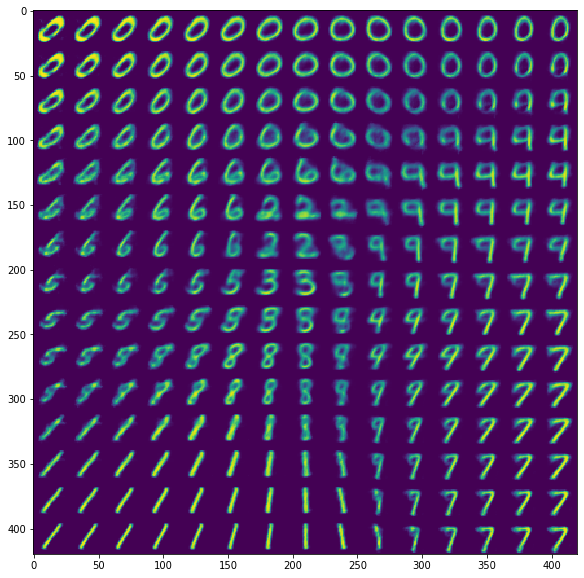

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

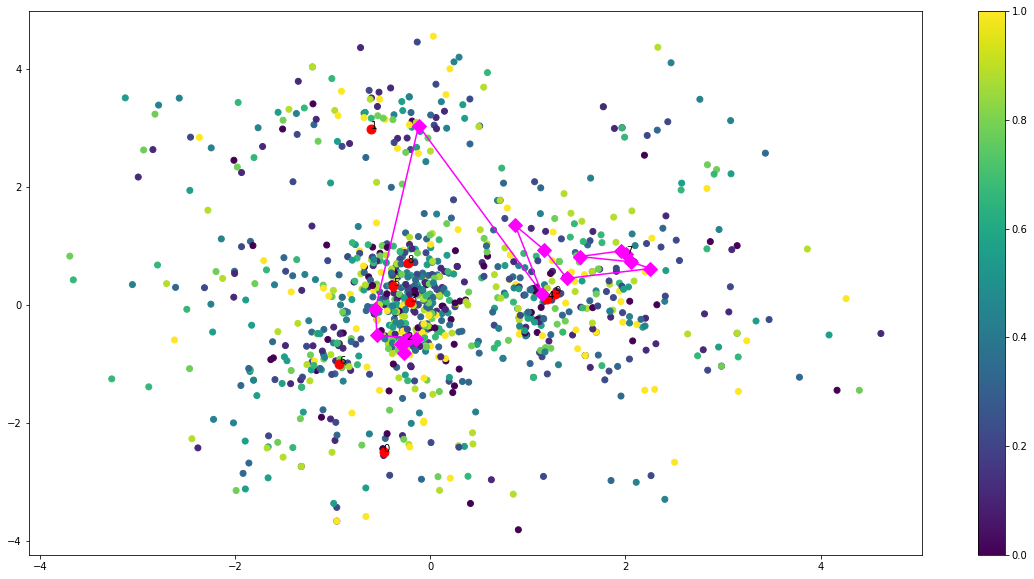

In [376]:
# Plotting the graph for consistency and looking where does each class belong
plt.figure(figsize=(20, 10))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], c=sampled_labels)
plt.scatter(centroids.keys(), centroids.values(), color='red', s=80)
plt.plot(resultant_points[:,0], resultant_points[:,1], '-D',markersize=10, color='fuchsia')

for i, key in enumerate(list(centroids.keys())):
    plt.annotate(i, (key, list(centroids.values())[i]))

plt.colorbar()
plt.show()

In [87]:
## Making centroids for each of the cluster
centroids = dict()
unique_labels = np.unique(y_test)
for i in unique_labels:
    cluster_indices = np.where(y_test == i)[0]
    cluster_points = x_test_encoded[cluster_indices]
    
    # Calculate the median not the mean since it ignores outliers 
    # and find the centroid based on the distribution of the points
    median_one = np.median(cluster_points[:, 0])
    median_two = np.median(cluster_points[:, 1])
    centroids[median_one] = median_two
    
print(centroids)

{-0.47944596: -2.4831343, -0.6072673: 2.9985144, -0.24861374: -0.582083, -0.20741743: 0.051544175, 1.1983323: 0.108305514, -0.3857699: 0.32242203, -0.93428683: -0.989365, 2.009448: 0.862861, -0.23255002: 0.7203881, 1.2728893: 0.19369775}


In [303]:
list_centroids = list(zip(centroids.keys(), centroids.values()))
list_centroids = np.array(list_centroids)
list_centroids

array([[-0.47944596, -2.4831343 ],
       [-0.6072673 ,  2.9985144 ],
       [-0.24861374, -0.582083  ],
       [-0.20741743,  0.05154417],
       [ 1.1983323 ,  0.10830551],
       [-0.3857699 ,  0.32242203],
       [-0.93428683, -0.989365  ],
       [ 2.009448  ,  0.862861  ],
       [-0.23255002,  0.7203881 ],
       [ 1.2728893 ,  0.19369775]], dtype=float32)

In [343]:
def generate_images_interp(x_vals, y_vals, n=10):
    ## Helper function: to generate images based on values
    ## of X and Y generated from the interpolation function
    # display a 2D manifold of the digits
    digit_size = 28 # Size of the digits
    interp_figure = np.zeros((digit_size * n, digit_size))
    cnt = 0

    for i in zip(x_vals, y_vals):
        xi, yi = i[0], i[1]
        z_val = np.array([[xi, yi]])
        x_decoded = generator.predict(z_val)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        interp_figure[cnt * digit_size: (cnt + 1) * digit_size] = digit
        cnt += 1
    
    plt.figure(figsize=(10, 10))
    plt.imshow(interp_figure)
    plt.show()

## Riemannian Latent space interpolation

### Graph building

In [66]:
import keras.backend as K
from sklearn.neighbors import NearestNeighbors
graph_cnt = 0
import time

In [67]:
sess = tf.Session()

In [68]:
sess.run(tf.global_variables_initializer())

In [384]:
class RiemannianMetricTest(object):
    def __init__(self, decoder_input, decoder_output, session):
        self.decoder_output = decoder_output
        self.decoder_input = decoder_input
        self.session = session
        self.process_time = time.time() # Seconds when the process started

    def create_metrics(self):
        # the metric tensor
        output_dim = self.decoder_output.shape[1].value
        # Finding the gradient of costs with respect to input
        J = [
            tf.gradients(self.decoder_output[:, _], self.decoder_input)[0] 
            for _ in tqdm_notebook(range(output_dim))
        ]
        J = tf.stack(J, axis=1)
        self.J = J
        # Riemannian metric
        G = tf.transpose(J, [0, 2, 1]) @ J 
        self.G = G

    def get_riemannian_distance(self, z1, z2):
        n_steps = 10
        t = np.linspace(0, 1, n_steps)
        dt = t[1] - t[0]
        # Get all the n_steps of equidistant points
        the_line = np.vstack([_ * z1 + (1 - _) * z2 for _ in t])
        G_eval = self.session.run(self.G, feed_dict={self.decoder_input: the_line})
        # Calculating the observation space distance between 2 points in the space
        # @ operator is a shorthand for matrix multiplication
        L_discrete = np.sqrt((z1-z2) @ G_eval @ (z1-z2).T)
        L_discrete = L_discrete.flatten()
        distance = np.sum(dt * L_discrete)
        global graph_cnt
        graph_cnt += 1
        if graph_cnt % 1000 == 0:
            time_finished = time.time()
            time_lapsed = (time_finished - self.process_time) / 60
            print('We are this epoch: {} in the graph with time lapsed : {} minutes'.format(graph_cnt, time_lapsed))
            self.process_time = time_finished
        return distance

In [385]:
rmetric = RiemannianMetricTest(
    generator.input, generator.output, sess
)

In [386]:
rmetric.create_metrics() # Construct the initial G and J graph

In [387]:
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')

### Path finding process

In [388]:
import networkx as nx
import kdtree

In [389]:
sampled_indices = np.random.randint(10000, size=(1000,))
sampled_points = x_test_encoded[sampled_indices]
sampled_labels = y_test[sampled_indices]

In [390]:
points_for_tree = np.vstack((sampled_points, list_centroids)) ## 10010, 2
points_for_tree.shape

(1010, 2)

In [391]:
knn.fit(points_for_tree)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
G = nx.Graph()
n_data = len(points_for_tree)

# Nodes
for i in range(n_data):
    n_attr = {f'z{k}': float(points_for_tree[i, k]) for k in range(points_for_tree.shape[1])}
    G.add_node(i, **n_attr)

# edges
for i in tqdm_notebook(range(n_data)):
    distances, indices = knn.kneighbors(points_for_tree[i:i+1])
    # first dim is for samples (z), but we only have one
    distances, indices = distances[0], indices[0]

    for ix, dist in zip(indices, distances):
        # calculate the riemannian distance of z[i] and its nn

        # save some computation if we alrdy calculated the other direction
        if (i, ix) in G.edges or (ix, i) in G.edges or i == ix:
            continue

        L_riemann = rmetric.get_riemannian_distance(points_for_tree[i:i+1], points_for_tree[ix:ix+1])
        L_euclidean = dist

        # note nn-distances are NOT symmetric
        edge_attr = {'weight': float(1/L_riemann),
                     'weight_euclidean': float(1/L_euclidean),
                     'distance_riemann': float(L_riemann),
                     'distance_euclidean': float(L_euclidean)}
        G.add_edge(i, ix, **edge_attr)

We are this epoch: 40000 in the graph with time lapsed : 6.222651469707489 minutes


In [358]:
tree = kdtree.create(points_for_tree.tolist())
tree = tree.rebalance()

In [359]:
adjacency_matrix = np.zeros((points_for_tree.shape[0], points_for_tree.shape[0]))

In [360]:
def inorder_(node):
    if node.left:
        start = np.where(points_for_tree == np.array(node.data))[0][0]
        target = np.where(points_for_tree == np.array(node.left.data))[0][0]
        adjacency_matrix[start][target] = 1
        adjacency_matrix[target][start] = 1
        inorder_(node.left)
        
    if node.right:
        start = np.where(points_for_tree == np.array(node.data))[0][0]
        target = np.where(points_for_tree == np.array(node.right.data))[0][0]
        adjacency_matrix[start][target] = 1
        adjacency_matrix[target][start] = 1
        inorder_(node.right)

In [361]:
# Inorder convert the tree into an adjacency matrix so that it can be fed into networkx
inorder_(tree)

In [362]:
# Check what values of the adjacency matrix have - there should be more ones
len(np.where(adjacency_matrix == 1)[0]) # Should be around 20000 since KD-trees are binary

1973

In [363]:
G = nx.Graph(adjacency_matrix)

In [364]:
edges = list(G.edges)

for edge_i in tqdm_notebook(range(len(edges))):
    start, target = edges[edge_i]
    # Get the encoded Z value
    latent_start = points_for_tree[start]
    latent_target = points_for_tree[target]
    # Assign weight to the edge
    r_distance = rmetric.get_riemannian_distance(latent_start, latent_target)
    G[start][target]['weight'] = r_distance

We are this epoch: 39000 in the graph with time lapsed : 23.592527890205382 minutes



In [365]:
starting_point = np.where(points_for_tree == np.array(list_centroids[2]))[0][0]
ending_point = np.where(points_for_tree == np.array(list_centroids[7]))[0][0]

print(starting_point in G)
print(ending_point in G)

True
True


In [366]:
def euclidean_dist(a, b):
    (x1, y1) = points_for_tree[a]
    (x2, y2) = points_for_tree[b]
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

result = nx.astar_path(G, starting_point, ending_point, heuristic=euclidean_dist, weight='weight')

In [367]:
print(len(result), result)

18 [1002, 246, 607, 390, 356, 405, 239, 191, 477, 624, 434, 437, 505, 161, 880, 116, 934, 1007]


In [368]:
resultant_points = np.array([list(points_for_tree[i]) for i in result])

In [369]:
resultant_points[:,0]

array([-0.24861374, -0.25761282, -0.22244605, -0.2733383 , -0.30497628,
       -0.14888856, -0.54879117, -0.5651485 , -0.12130489,  1.1437362 ,
        0.8699295 ,  1.1691301 ,  1.4005923 ,  2.256357  ,  2.0518076 ,
        1.5307125 ,  1.9538417 ,  2.009448  ], dtype=float32)

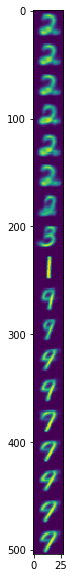

In [370]:
generate_images_interp(resultant_points[:,0], resultant_points[:,1], n=18)